In [51]:
import torch 
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler

In [52]:
file_path = 'Project/measures_v2.csv'

df = pd.read_csv(file_path)

df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [53]:
def apply_z_score_normalization_except_profile_id(df):
    
    profile_id = df['profile_id']
    
    df_to_scale = df.drop('profile_id', axis=1)

    scaler = StandardScaler()

    df_scaled = scaler.fit_transform(df_to_scale)

    df_scaled = pd.DataFrame(df_scaled, columns=df_to_scale.columns)

    df_scaled['profile_id'] = profile_id

    return df_scaled

In [54]:
def apply_z_score_normalization_by_profile_id2(df):
    # This list will hold the scaled data for each profile_id
    scaled_data_list = []
    
    # Creating a StandardScaler object
    scaler = StandardScaler()
    
    # Get unique profile_ids
    profile_ids = df['profile_id'].unique()
    
    # Loop over each profile_id to scale its data
    for profile_id in profile_ids:
        # Select data for the current profile_id
        profile_data = df[df['profile_id'] == profile_id]
        
        # Separate the 'profile_id' column
        profile_data_to_scale = profile_data.drop('profile_id', axis=1)
        profile_id_column = profile_data['profile_id']
        
        # Fit the scaler to the data of the current profile_id and transform it
        profile_scaled = scaler.fit_transform(profile_data_to_scale)
        
        # Create a DataFrame from the scaled data
        profile_scaled_df = pd.DataFrame(profile_scaled, columns=profile_data_to_scale.columns)
        
        # Add the 'profile_id' column back to the scaled DataFrame
        profile_scaled_df['profile_id'] = profile_id_column.values
        
        # Append the scaled data to the list
        scaled_data_list.append(profile_scaled_df)
    
    # Concatenate all the scaled data together
    df_scaled = pd.concat(scaled_data_list, ignore_index=True)
    
    return df_scaled


In [55]:

def add_ewa_features_by_profile_id(df, spans, exclude_columns):
    """
    Adds multiple exponentially weighted average columns for each original numeric column in the DataFrame 
    for each span value, grouped by 'profile_id'. New features are created only for the original columns.

    :param df: The DataFrame to which the EWA columns will be added.
    :param spans: A list of span values for the EWA calculation.
    :param exclude_columns: A list of column names to be excluded from the EWA calculation.
    :return: DataFrame with new EWA columns added for each span and each original numeric column.
    """
    # Ensure 'profile_id' is not in the exclude_columns
    exclude_columns = set(exclude_columns) | {'profile_id'}

    # List of original columns to apply EWA
    original_columns = [col for col in df.columns if col not in exclude_columns]

    # Iterate over each original column
    for col in original_columns:
        # Apply EWA for each span value
        for span in spans:
            # Define the column name for the EWA feature
            ewa_col_name = f'{col}_ewa_{span}'

            # Group by 'profile_id' and apply EWA using transform
            ewa_col = df.groupby('profile_id')[col].transform(lambda x: x.ewm(span=span, adjust=False).mean())

            # Add the new EWA column to the DataFrame
            df[ewa_col_name] = ewa_col

    return df


In [56]:
exclude_columns = ['pm']

In [57]:
spans= [600, 1200, 2400, 4800]

In [58]:
df_span = add_ewa_features_by_profile_id(df, spans, exclude_columns)

In [59]:
df_span.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_2400,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,...,18.316547,18.316547,19.850691,19.850691,19.850691,19.850691,0.187101,0.187101,0.187101,0.187101
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,...,18.316546,18.316547,19.850691,19.850691,19.850691,19.850691,0.187295,0.187198,0.187149,0.187125
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,...,18.316554,18.316551,19.850691,19.850691,19.850691,19.850691,0.187259,0.187180,0.187141,0.187121
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,...,18.316566,18.316557,19.850691,19.850691,19.850691,19.850691,0.187429,0.187265,0.187183,0.187142
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,...,18.316575,18.316561,19.850690,19.850691,19.850691,19.850691,0.187498,0.187300,0.187201,0.187151


In [60]:
df_span.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id', 'u_q_ewa_600', 'u_q_ewa_1200', 'u_q_ewa_2400',
       'u_q_ewa_4800', 'coolant_ewa_600', 'coolant_ewa_1200',
       'coolant_ewa_2400', 'coolant_ewa_4800', 'stator_winding_ewa_600',
       'stator_winding_ewa_1200', 'stator_winding_ewa_2400',
       'stator_winding_ewa_4800', 'u_d_ewa_600', 'u_d_ewa_1200',
       'u_d_ewa_2400', 'u_d_ewa_4800', 'stator_tooth_ewa_600',
       'stator_tooth_ewa_1200', 'stator_tooth_ewa_2400',
       'stator_tooth_ewa_4800', 'motor_speed_ewa_600', 'motor_speed_ewa_1200',
       'motor_speed_ewa_2400', 'motor_speed_ewa_4800', 'i_d_ewa_600',
       'i_d_ewa_1200', 'i_d_ewa_2400', 'i_d_ewa_4800', 'i_q_ewa_600',
       'i_q_ewa_1200', 'i_q_ewa_2400', 'i_q_ewa_4800', 'stator_yoke_ewa_600',
       'stator_yoke_ewa_1200', 'stator_yoke_ewa_2400', 'stator_yoke_ewa_4800',
       'ambient_ewa_600', 'ambi

In [61]:
df_norm = apply_z_score_normalization_by_profile_id2(df_span)

In [62]:
df_norm.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,...,stator_yoke_ewa_4800,ambient_ewa_600,ambient_ewa_1200,ambient_ewa_2400,ambient_ewa_4800,torque_ewa_600,torque_ewa_1200,torque_ewa_2400,torque_ewa_4800,profile_id
0,-4.910582,-0.256411,-3.724055,1.203295,-4.166397,-23.064819,5.561438,-1.101757,-3.910713,-4.202065,...,-2.993552,-3.369096,-3.092831,-2.722098,-2.310296,-1.083615,-1.131355,-1.247959,-1.555449,17
1,-4.904901,-0.227835,-3.723545,1.204285,-4.166190,-23.064831,5.561260,-1.101799,-3.912545,-4.202417,...,-2.993552,-3.369096,-3.092831,-2.722098,-2.310296,-1.083607,-1.131351,-1.247956,-1.555447,17
2,-4.910136,-0.206085,-3.723813,1.202793,-4.166283,-23.064822,5.561292,-1.101755,-3.911794,-4.199908,...,-2.993551,-3.369096,-3.092831,-2.722098,-2.310296,-1.083608,-1.131352,-1.247957,-1.555448,17
3,-4.904960,-0.191587,-3.724380,1.204053,-4.166485,-23.064804,5.561233,-1.101691,-3.910735,-4.198908,...,-2.993550,-3.369096,-3.092831,-2.722098,-2.310296,-1.083601,-1.131348,-1.247955,-1.555446,17
4,-4.911513,-0.145808,-3.724425,1.203693,-4.166631,-23.064818,5.558229,-1.100350,-3.909444,-4.199830,...,-2.993549,-3.369096,-3.092831,-2.722098,-2.310296,-1.083598,-1.131346,-1.247954,-1.555446,17


In [63]:
#function to trim sessions to an appropriate size
def preprocess(df, sessions_id, seq_len):
    target="pm"
    sessions = []
    for id in sessions_id:
        s = df[df["profile_id"] == id]

        #because the sequences based on the profile_id are not all the same lenghts, it takes the longest number of 
        #timestamps that is divisible for the seq_len that will be passed to our model

        #for each sequences we will lost a little bit of the dataset ( no more than the sequence_length = 100)
        r = len(s) % seq_len
        l = len(s) - r
        
        session = s.iloc[:l]
        
        y = session[target]
        X = session.drop([target, "profile_id"], axis=1)
        
        X = torch.from_numpy(X.values).float() 
        y = torch.from_numpy(y.values).float()

        sessions.append((X, y))
        
    return sessions

In [82]:
#Bidirectional LSTM class
class NET(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(h_size * 2, out_size)
             
    def forward(self, x):
        #init. states 
        h0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        c0 = torch.zeros(self.n_layers * 2, x.size(0), self.h_size)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out)
        return out 

In [83]:
#defining the sequence length and the sessions ids which are used for training
seq_len = 100
# ids = [4, 6, 10, 11, 20, 27, 29, 30, 31,32, 36] + [i+41 for i in range(35)]

ids = [20, 6, 65, 18, 66, 13, 27, 4, 58, 56, 53, 79, 44, 70, 62, 30, 80, 74, 68, 36, 76, 48, 12, 29, 32, 16, 9, 2, 3, 8, 14, 15, 81, 21, 45, 42, 73, 41, 63, 26, 17, 31, 69]
all_profile = df_norm['profile_id'].tolist()
unique_profiles = list(set(all_profile))
testing_id = [item for item in unique_profiles if item not in ids]
print(testing_id)
training = preprocess(df_norm, ids, seq_len)
testing = preprocess(df_norm, testing_id, seq_len)
print(training)

#create an lstm instance
model = NET(55, 20, 2, 1)
print(model)

#define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

[5, 7, 10, 11, 19, 23, 24, 43, 46, 47, 49, 50, 51, 52, 54, 55, 57, 59, 60, 61, 64, 67, 71, 72, 75, 78]
[(tensor([[-1.4824, -0.6841, -1.6130,  ..., -1.3148, -1.5595, -2.0016],
        [-1.4813, -0.6840, -1.6123,  ..., -1.3148, -1.5595, -2.0016],
        [-1.4849, -0.6836, -1.6113,  ..., -1.3148, -1.5595, -2.0016],
        ...,
        [-0.2886, -0.7834,  0.5318,  ...,  1.2221,  1.3855,  1.3690],
        [-0.2883, -0.7844,  0.5334,  ...,  1.2221,  1.3856,  1.3693],
        [-0.2902, -0.7831,  0.5370,  ...,  1.2221,  1.3857,  1.3697]]), tensor([-2.0679, -2.0672, -2.0674,  ...,  0.9243,  0.9238,  0.9236])), (tensor([[-1.7179, -0.6755, -1.9961,  ...,  0.4382,  0.4655,  0.5180],
        [-1.7151, -0.6747, -1.9966,  ...,  0.4382,  0.4655,  0.5181],
        [-1.7131, -0.6742, -1.9972,  ...,  0.4383,  0.4655,  0.5181],
        ...,
        [-1.0752, -0.5975, -1.6548,  ...,  0.6100,  0.6581,  0.5889],
        [-1.0752, -0.5964, -1.6546,  ...,  0.6100,  0.6581,  0.5889],
        [-1.0752, -0.5951

In [84]:
n_epochs = 50

#train model
train_losses = []

model.train()
for e in range(n_epochs):
    for X, y in training:
        optimizer.zero_grad()
        out = model.forward(X.view(-1, seq_len, 55))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

RuntimeError: Expected hidden[0] size (2, 439, 20), got [4, 439, 20]

In [69]:
def validate(model, testing_data, criterion, seq_len):
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Turn off gradients for validation
        for X, y in testing_data:
            # Forward pass
            out = model.forward(X.view(-1, seq_len, 55))
            # Calculate the loss
            loss = criterion(out, y.view(-1, seq_len, 1))
            # Record the loss
            val_losses.append(loss.item())
    return val_losses

# Perform validation
val_losses = validate(model, testing, criterion, seq_len)

# Calculate average validation loss
avg_val_loss = np.mean(val_losses)
print(f'Average validation loss: {avg_val_loss:.4f}')

Average validation loss: 0.1525


**LSTM NOT BIDIRETIONAL**

In [88]:
class NET2(nn.Module):
    def __init__(self, in_size, h_size, n_layers, out_size):
        super(NET2, self).__init__()
        self.h_size = h_size
        self.n_layers = n_layers
        self.out_size = out_size
        self.lstm = nn.LSTM(in_size, h_size, n_layers, batch_first=True, bidirectional=False)
        self.fc = nn.Linear(h_size, out_size)  
             
    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.h_size).to(x.device)
        c0 = torch.zeros(self.n_layers, x.size(0), self.h_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out)  # Apply fully connected layer to each time step
        return out




In [89]:
#create an lstm instance
model2 = NET2(55, 20, 2, 1)
print(model2)

#define optimizer and loss function
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.MSELoss()

NET2(
  (lstm): LSTM(55, 20, num_layers=2, batch_first=True)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)


Epoch [1/50], Loss: 0.0179
Epoch [2/50], Loss: 0.0176
Epoch [3/50], Loss: 0.0175
Epoch [4/50], Loss: 0.0176
Epoch [5/50], Loss: 0.0175
Epoch [6/50], Loss: 0.0168
Epoch [7/50], Loss: 0.0167
Epoch [8/50], Loss: 0.0167
Epoch [9/50], Loss: 0.0167
Epoch [10/50], Loss: 0.0161
Epoch [11/50], Loss: 0.0158
Epoch [12/50], Loss: 0.0159
Epoch [13/50], Loss: 0.0157
Epoch [14/50], Loss: 0.0154
Epoch [15/50], Loss: 0.0151
Epoch [16/50], Loss: 0.0150
Epoch [17/50], Loss: 0.0150
Epoch [18/50], Loss: 0.0147
Epoch [19/50], Loss: 0.0142
Epoch [20/50], Loss: 0.0142
Epoch [21/50], Loss: 0.0141
Epoch [22/50], Loss: 0.0139
Epoch [23/50], Loss: 0.0134
Epoch [24/50], Loss: 0.0136
Epoch [25/50], Loss: 0.0137
Epoch [26/50], Loss: 0.0132
Epoch [27/50], Loss: 0.0132
Epoch [28/50], Loss: 0.0133
Epoch [29/50], Loss: 0.0128
Epoch [30/50], Loss: 0.0125
Epoch [31/50], Loss: 0.0128
Epoch [32/50], Loss: 0.0127
Epoch [33/50], Loss: 0.0121
Epoch [34/50], Loss: 0.0119
Epoch [35/50], Loss: 0.0120
Epoch [36/50], Loss: 0.0116
E

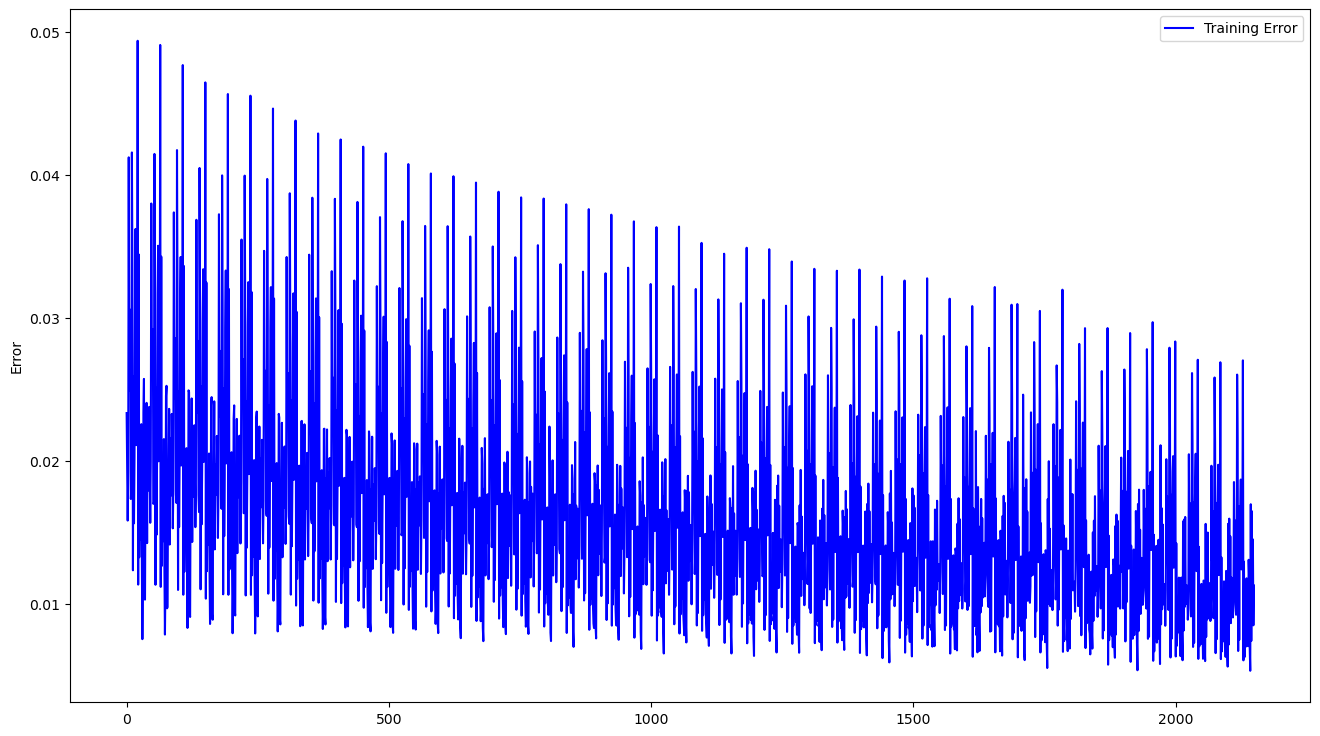

In [95]:
n_epochs = 50

#train model
train_losses = []

model2.train()
for e in range(n_epochs):
    for X, y in training:
        optimizer.zero_grad()
        out = model2.forward(X.view(-1, seq_len, 55))
        loss = criterion(out, y.view(-1, seq_len, 1))
        
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    
    print(f'Epoch [{e+1}/{n_epochs}], Loss: {loss.item():.4f}')
    
#print training error
plt.rcParams["figure.figsize"] = [16, 9]
plt.plot(train_losses, 'b', label='Training Error')
plt.legend(loc='upper right')
plt.ylabel('Error')
plt.show()

In [96]:
def validate(model, testing_data, criterion, seq_len):
    model.eval()  # Set the model to evaluation mode
    val_losses = []
    with torch.no_grad():  # Turn off gradients for validation
        for X, y in testing_data:
            # Forward pass
            out = model.forward(X.view(-1, seq_len, 55))
            # Calculate the loss
            loss = criterion(out, y.view(-1, seq_len, 1))
            # Record the loss
            val_losses.append(loss.item())
    return val_losses

# Perform validation
val_losses = validate(model2, testing, criterion, seq_len)

# Calculate average validation loss
avg_val_loss = np.mean(val_losses)
print(f'Average validation loss: {avg_val_loss:.4f}')

Average validation loss: 0.1495


In [104]:
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import numpy as np

# Extract the first sequence from your testing data
X, y = testing[0]

# Assuming X is of shape (num_batches, seq_len, num_features)
num_batches = X.shape[0]

all_predictions = []

model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for i in range(num_batches):
        # Extract each subsequence (batch)
        subsequence = X[i].view(1, seq_len, 55)  # Reshape to match the model's expected input shape

        # Get the model's prediction for this subsequence
        prediction = model2(subsequence)  # Make sure the data is on the same device as the model
        prediction_np = prediction.cpu().numpy().squeeze()  # Convert to NumPy array and remove batch dimension

        # Append the prediction to the list
        all_predictions.append(prediction_np)

# Concatenate all predictions to form a continuous series
all_predictions_np = np.concatenate(all_predictions)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(all_predictions_np, label='Predicted Time Series')
plt.xlabel('Time Step')
plt.ylabel('Predicted Value')
plt.title('Time Series Prediction for the First Sequence')
plt.legend()
plt.show()



RuntimeError: shape '[1, 100, 55]' is invalid for input of size 55